In [ ]:
### Shane Kramer
### 207 Final Project - Exploring Naive Bayes Models
### 03.27.22 - Naive Bayes model with weighting scoring, upscaling, downscaling

In [2]:
from pandas import json_normalize
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import nltk
import numpy as np 
import pandas as pd 
import json 
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def plotConfusionMatrix(cnf_matrix):
  # Plot results
  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [16]:
# Can configure the list below to filter columns from original training data set
test_cols = ['request_text', 'request_number_of_comments_at_retrieval', 'requester_received_pizza']

# Read JSON file
df = pd.read_json('/content/drive/MyDrive/W207/FinalProject/w207_final_project/src/data/train.json')

# For the entire training set, add column for request text count, create label obejct, 
# And purge the request_texct_count column from training data
full_df = df.copy()
full_df['request_text_count'] = df['request_text'].str.count(' ') + 1
full_labels = full_df['requester_received_pizza']
full_df = full_df.drop('requester_received_pizza', axis=1)

# Not filtering columns for now
#filtered_df = df[test_cols]

dev_size=1000

# Build train and dev data sets
train_data, train_labels = full_df.request_text[dev_size:], full_labels[dev_size:]
dev_data, dev_labels = full_df.request_text[:dev_size], full_labels[:dev_size]

In [9]:
print("###################################################################")
print("Tuning Naive Bayes Alpha for baseline model (score weighted).")
print("###################################################################")

vectorizer = CountVectorizer()
trainVector = vectorizer.fit_transform(train_data)
devVector = vectorizer.transform(dev_data)

for i in [.0001, .001, .01, .05, .06, .07, .08, .09, .1, .11, .5, 1.0, 2.0]:
      
  mnb = MultinomialNB(alpha = i)
  mnb.fit(trainVector, train_labels)

  #Evaluate performance on the dev set.
  pred_mnb = mnb.predict(devVector)
  score = metrics.f1_score(dev_labels, pred_mnb, average="weighted")
  print("     a =", i, " - f1 score =", score)

###################################################################
Tuning Naive Bayes Alpha for baseline model (score weighted).
###################################################################
     a = 0.0001  - f1 score = 0.668475
     a = 0.001  - f1 score = 0.6677606796018085
     a = 0.01  - f1 score = 0.6708568829248878
     a = 0.05  - f1 score = 0.667934345758552
     a = 0.06  - f1 score = 0.6701334560515416
     a = 0.07  - f1 score = 0.6730585091260589
     a = 0.08  - f1 score = 0.6723325663445313
     a = 0.09  - f1 score = 0.6700974626398354
     a = 0.1  - f1 score = 0.6715402298850575
     a = 0.11  - f1 score = 0.6715402298850575
     a = 0.5  - f1 score = 0.6568691782147799
     a = 1.0  - f1 score = 0.6395443925233647
     a = 2.0  - f1 score = 0.6292905273564535



###################################################################
Plot confusion matrix results for 3000/1000 NB with Alpha = .07
###################################################################


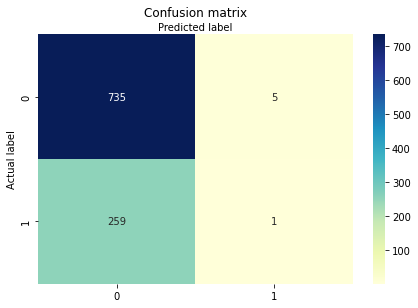

In [18]:
print("")
print("###################################################################")
print("Plot confusion matrix results for 3000/1000 NB with Alpha = .07")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(dev_labels, pred_mnb)
plotConfusionMatrix(cnf_matrix)

It looks like the optimal alpha for our model is .07 with an f1 score of 0.67306.

Lets preprocess the data first and see what we can accomplish. 

In [21]:
print("")
print("###################################################################")
print("Let's see if pre-processing the data helps at all.")
print("###################################################################")

nltk.download('stopwords')
    
cachedStopWords = stopwords.words("english")
ps = PorterStemmer()

def myPreprocessor(data):
   filteredData = re.sub('[^A-Za-z0-9 \n]+', ' ', data.lower())
   filteredData = ' '.join([word for word in filteredData.split() 
      if word not in cachedStopWords])
   filteredData = ' '.join([word[0:6] if len(word) > 6 else 
                            word for word in filteredData.split()])
   #print(filteredData)
   return filteredData

ppVectorizer = CountVectorizer(preprocessor=myPreprocessor)
ppTrainVector = ppVectorizer.fit_transform(train_data)
ppDevVector = ppVectorizer.transform(dev_data)

mnb = MultinomialNB(alpha = .07)
mnb.fit(ppTrainVector, train_labels)

#Evaluate performance on the dev set.
pred_mnb2 = mnb.predict(ppDevVector)
score = metrics.f1_score(dev_labels, pred_mnb, average="weighted")
print("     a = .07 - f1 score =", score)


###################################################################
Let's see if pre-processing the data helps at all.
###################################################################
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     a = .07 - f1 score = 0.6292905273564535



###################################################################
Plot confusion matrix results for 3000/1000 pre-processed NB with  
Alpha = .07                                                        
###################################################################


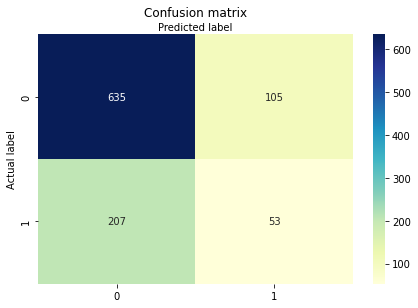

In [22]:
print("")
print("###################################################################")
print("Plot confusion matrix results for 3000/1000 pre-processed NB with  ")
print("Alpha = .07                                                        ")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(dev_labels, pred_mnb2)
plotConfusionMatrix(cnf_matrix)

Maybe TF-IDF?

In [23]:
print("")
print("###################################################################")
print("Give TF-IDF a whirl ...                                            ")
print("###################################################################")
tfidfVectorizer = TfidfVectorizer()
tfidTrainVector = tfidfVectorizer.fit_transform(train_data)
tfidDevVector = tfidfVectorizer.transform(dev_data)

for i in [.0001, .001, .01, .05, .06, .07, .08, .09, .1, .11, .5, 1.0, 2.0]:
  mnb = MultinomialNB(alpha = i)
  mnb.fit(tfidTrainVector, train_labels)

  #Evaluate performance on the dev set.
  pred_mnb3 = mnb.predict(tfidDevVector)
  score = metrics.f1_score(dev_labels, pred_mnb, average="weighted")
  print("     a =", i, " - f1 score =", score)


###################################################################
Give TF-IDF a whirl ... 
###################################################################
     a = 0.0001  - f1 score = 0.6292905273564535
     a = 0.001  - f1 score = 0.6292905273564535
     a = 0.01  - f1 score = 0.6292905273564535
     a = 0.05  - f1 score = 0.6292905273564535
     a = 0.06  - f1 score = 0.6292905273564535
     a = 0.07  - f1 score = 0.6292905273564535
     a = 0.08  - f1 score = 0.6292905273564535
     a = 0.09  - f1 score = 0.6292905273564535
     a = 0.1  - f1 score = 0.6292905273564535
     a = 0.11  - f1 score = 0.6292905273564535
     a = 0.5  - f1 score = 0.6292905273564535
     a = 1.0  - f1 score = 0.6292905273564535
     a = 2.0  - f1 score = 0.6292905273564535



###################################################################
Plot confusion matrix results for 3000/1000 TF-IDF with            
Alpha = .07                                                        
###################################################################


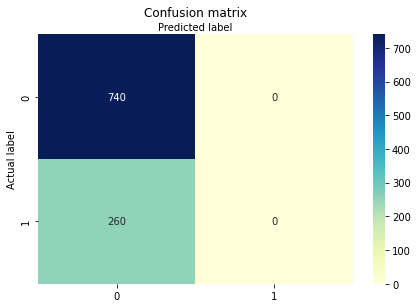

In [25]:
print("")
print("###################################################################")
print("Plot confusion matrix results for 3000/1000 TF-IDF with            ")
print("Alpha = .07                                                        ")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(dev_labels, pred_mnb3)
plotConfusionMatrix(cnf_matrix)

In [27]:
print("")
print("###################################################################")
print("TF-IDF with pre-processing ... ")
print("###################################################################")
tfidfVectorizer = TfidfVectorizer(preprocessor=myPreprocessor)
tfidTrainVector = tfidfVectorizer.fit_transform(train_data)
tfidDevVector = tfidfVectorizer.transform(dev_data)

mnb = MultinomialNB(alpha = .001)
mnb.fit(tfidTrainVector, train_labels)

#Evaluate performance on the dev set.
pred_mnb4 = mnb.predict(tfidDevVector)
score = metrics.f1_score(dev_labels, pred_mnb, average="weighted")
print("     a = .07 - f1 score =", score)


###################################################################
TF-IDF with pre-processing ... 
###################################################################
     a = .07 - f1 score = 0.6292905273564535



###################################################################
Plot confusion matrix results for 3000/1000 pre-processed TF-IDF   
with alpha = .07                                                   
###################################################################


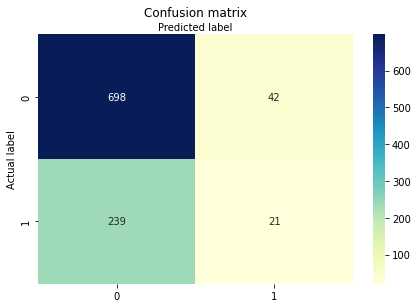

In [28]:
print("")
print("###################################################################")
print("Plot confusion matrix results for 3000/1000 pre-processed TF-IDF   ")
print("with alpha = .07                                                   ")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(dev_labels, pred_mnb4)
plotConfusionMatrix(cnf_matrix)

It looks like the best I could do is by training on 75% (ish) of the data, tested against 25% (about 3000 and 1000 respectively), running basic multinomial NB model against data that isn't preprocessed, and using an alpha of .07. This achieves an F1 score of 0.67306.